<a href="https://colab.research.google.com/github/ishiyeahman/RL-test/blob/main/RL_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [464]:
## 関数定義

# 任意の閉路を生成
def set_tsp_graph(edge_list):
    new_g = nx.Graph()
    new_g.add_edges_from(edge_list)
    
    return new_g

# 閉路における経路長などを算出
def result_tsp(graph):
    print(" sum of all path : ", graph.size(weight="weight"))


# グラフの表示設定
def draw_networkx_config(graph, pos):

    # 重みをラベリング
    edge_labels = nx.get_edge_attributes(graph , 'weight')

    nx.draw(graph, pos)
    nx.draw_networkx_labels(graph,pos)
    nx.draw_networkx_edge_labels(graph, pos  ,edge_labels=edge_labels)
    # plt.show()


# ユークリッド距離を設定
def set_euclidean_distance(graph, pos):
    for i, j in graph.edges:
        graph[i][j]['weight'] =  np.linalg.norm(pos[i]-pos[j])


    return graph



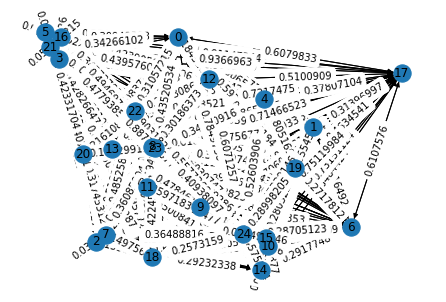

In [595]:
# 問題設定
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

CITY_NUM = 25

#generate edge
p = 1
seed = 42

g = nx.random_graphs.fast_gnp_random_graph(CITY_NUM, p, seed, directed = True)
pos = nx.random_layout(g, seed=seed)



labels = list(range(1, CITY_NUM))

#ユークリッド距離を計算し辺の重みとする
g = set_euclidean_distance(g, pos)

draw_networkx_config(g, pos)
plt.show()


In [596]:
nbs = [n for n in g.neighbors(0)]
nbs_weight = {}
for i in nbs:
    w = {i : g[0][i]['weight']}
    nbs_weight.update(w)

min_key = min(nbs_weight, key=nbs_weight.get)
print(min_key)
print(nbs_weight)


12
{1: 0.5017136, 2: 0.8242155, 3: 0.3275537, 4: 0.33198065, 5: 0.35447574, 6: 0.8688341, 7: 0.7911406, 8: 0.4317197, 9: 0.66197884, 10: 0.84521943, 11: 0.59013283, 12: 0.18452655, 13: 0.4702052, 14: 0.93014103, 15: 0.8142407, 16: 0.30949393, 17: 0.6079833, 18: 0.8559034, 19: 0.59714574, 20: 0.5208373, 21: 0.34266102, 22: 0.31057215, 23: 0.43520534, 24: 0.7849738}


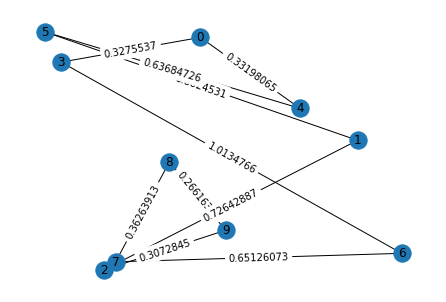

In [467]:
# random tsp  
import random

node_list  = list(g.nodes)
random_edge = []
begin_node = random.randint(0, len(node_list)-1)

first_node = begin_node
node_list.pop(first_node)

for i in range(len(node_list)):
    while True:
            index = random.randint(0, len(node_list)-1)
            if node_list[index] != first_node:
                break

    second_node =  node_list.pop(index)
    random_edge += [(first_node, second_node)]
    first_node = second_node
    
random_edge += [(begin_node, second_node)]


    
new_g = set_tsp_graph(random_edge)
new_g = set_euclidean_distance(new_g, pos)
draw_networkx_config(new_g, pos)
plt.show()

### 参考文献 
- O'REILLY Python による AIプログラミング入門
- https://qiita.com/maskot1977/items/7b64a67a6c489f47e909

---
## Q学習

### アルゴリズム
1. Q値を初期化する
2. for i = 1 to [タスクのトライアル数] do
    3. 時刻t=1として$S_0$を観測
    4. repeat
        5. 方策$π$にしたがって$a_t$を選択して行動
        6. 環境から$r_{t+1}$と$S_{t+1}$を観測
        7. Q学習の更新式に従って$Q(s_t, a_t)$の値を更新
        8. 時刻 $t ← t + 1$とする
    9. until ゴールに到達 or 終了条件に到達
10. end for

### 更新式
$Q(s_t, a) ← Q(s_t, a) + \alpha [ r_{t+1} + γ \max_p Q(s_{t+1}, p) - Q(s_t, a)]$ 

### 行動選択の方策
- greedyに最短を取り続けても，完成された閉路の巡回経路が最短とは限らない
- 隣接した都市へ移動する場合には，一般的に最短の経路を選択するのは妥当
- ランダムで他の都市を選択する

$ϵ - greedy$法を用いる

In [628]:
import random
import copy

# Q-learning 

class Agent:
    def __init__(self):
        self.Q_table = None 
        self.last_state = None
        self.last_action = None
        self.epsilon = None
        self.Graph = None
        self.reached = []

        

    def set_state(self, state):
        self.last_state = state

    def init_Q_table(self, states_size, actions_size):
        self.Q_table = np.zeros([states_size,actions_size])
        for i in range(len(self.Q_table)):
            self.Q_table[i][i] = -np.infty
        
    def set_prameter(self, _alpha=0.1,  _gamma=0.1, _epsilon=0.1):
        self.alpha = _alpha
        self.gamma = _gamma
        self.epsilon = _epsilon
        
    def set_env(self, _Graph):
        self.Graph = _Graph

    def reset(self):
        self.last_state = None
        self.last_action = None
        self.reached = []
        

        


    def get_possible_reache_neighbor_list(self, Graph, state_node, reached):
        # 隣接したノードを取得
        nbs = [n for n in Graph.neighbors(state_node)]
        
        
        # 過去の通過したノードを削除
        for reached_state in reached:
            if reached_state in nbs:
                nbs.remove(reached_state)

        return nbs


    def get_min_path_state(self, Graph, state_node, nbs):

        # path weight を計算
        nbs_weight = {}
        for i in nbs:
            w = {i : Graph[state_node][i]['weight']}
            nbs_weight.update(w)

        min_state_key = min(nbs_weight, key=nbs_weight.get)
        # print(nbs_weight)

        # 最小のパスで隣接するノードを返す
        return min_state_key



    def select_action(self, episode):
        
        pr_nbs = self.get_possible_reache_neighbor_list(self.Graph, self.last_state, self.reached)

        # 巡回路が完成しているならば行動しない
        if len(pr_nbs) == 0:
            return -1

        # epsilon - greedy 
        r = random.random()
        if r < self.epsilon *  ( 1 / (episode + 1)) :
        # if r < self.epsilon *  ( 1 / (CITY_NUM - len(pr_nbs) ) + 1) *  ( 1 / (episode + 1)):    
            next_state = random.choice(pr_nbs)
        else:
            next_state = self.get_min_path_state(self.Graph, self.last_state, pr_nbs)

        # ここでは，next_stateは次へ移動すべきノードを表す．したがって，next_actionはnext_stateへ移動することを表す
        next_action = next_state

        return next_action
        
    def train(self, s, a, r, s_next):
        target_list = copy.deepcopy(self.Q_table[s_next,:])

        if s_next == self.reached[0]:
            target_list = 0
        else:  
            # mask the node that agent can't reach 
             
            for r_i in self.reached:
                target_list[r_i] = -np.inf
                if np.max( target_list ) == -np.inf:
                    target_list = self.Q_table[s_next,0]
                    # print(s_next)
                    # print(self.reached)
                    # print(self.Q_table)
        self.Q_table[s,a] = self.Q_table[s,a] + self.alpha * (r + self.gamma*np.max( target_list ) - self.Q_table[s,a])


    def add_reached(self, node_name):
         self.reached += [node_name]

    






In [611]:
def run(episode):
    next_a  = agent.select_action(episode)
    

    if next_a == -1:
        reward = ( 1 / g[agent.last_state][init_state]['weight']) * 100
        # reward_acc += 1 / g[agent.last_state][init_state]['weight'] 
        agent.train(agent.last_state, init_state, reward, init_state) #acc

        return False

    # path weight が小さいとき 報酬大

    reward = -  g[agent.last_state][next_a]['weight']
    
    # reward_acc += 1 / g[agent.last_state][init_state]['weight'] 
    agent.train(agent.last_state, next_a, reward, next_a) #acc
 
    agent.add_reached(next_a)

    agent.set_state(next_a)
    
    


    return  True

In [633]:
import matplotlib.pyplot as plt

init_state = 0
agent = Agent()
agent.set_env(g)
agent.set_state( init_state )
agent.add_reached( init_state )
agent.init_Q_table(g.number_of_nodes(), g.number_of_nodes() )
agent.set_prameter(_alpha=0.1,  _gamma=0.99, _epsilon=0.3)

EPISODE = 300
G_SIZE = []


for i in range(EPISODE):
    
    agent.reset()
    agent.set_state( init_state )
    agent.add_reached( init_state )

    while(run(i)):
        # print(agent.Q_table)
        # print(agent.reached)
        
        None

    G_SIZE += [ get_tsp_size( agent, init_state)]



    """ make path """
    pre_node = init_state
    path = []
    for i in range(1, len(agent.reached)):
        next_node = agent.reached[i]
        path += [(pre_node, next_node)]
        pre_node = next_node

    path += [(pre_node, init_state)]
    
    new_g = set_tsp_graph(path )



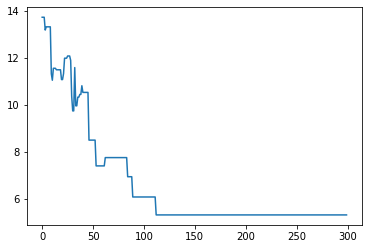

In [634]:
plt.plot(list(range(EPISODE)), G_SIZE)


In [635]:

def custom_max(base_list, prohibit_list):



    for i in range(len(base_list)):
        if i in prohibit_list:
            base_list[i] = -np.inf


    return np.argmax( base_list)

    

def get_tsp_pie(table, begin_node):

    pie = np.zeros_like(table)

    done_node = [ begin_node]
    next = begin_node
    while(1):

        max_node = custom_max( copy.deepcopy(table[next,:]), done_node)
        pie[next][  max_node] = 1
        done_node += [ max_node]
        next = max_node

        if len(done_node) == len( table[next,:]):
            done_node.remove(begin_node)
            max_node = custom_max( copy.deepcopy(table[next,:]), done_node)
            pie[next][  max_node] = 1
            break
            

    return pie
    


def get_tsp_size( agent, init_state):
    

    pie = get_tsp_pie( copy.deepcopy(agent.Q_table), init_state)
    max_index_list = list(pie.argmax(axis = 1))

    path = []
    for i in range(len(max_index_list)):
        path += [(i, max_index_list[i])] 

    new_g = set_tsp_graph(path )
    new_g = set_euclidean_distance(new_g, pos)
    
    return new_g.size(weight="weight")
   

   




[12 19 11 21  1  9 15  2 13 17 24 23  4 20 18 10  5  0  7  6 22 16  3  8
 14]
[12 19 11 21  1  9 15  2 13 17 24 23  4 20 18 10  5  0  7  6 22 16  3  8
 14]


[(0, 12),
 (1, 19),
 (2, 11),
 (3, 21),
 (4, 1),
 (5, 9),
 (6, 15),
 (7, 2),
 (8, 13),
 (9, 17),
 (10, 24),
 (11, 23),
 (12, 4),
 (13, 20),
 (14, 18),
 (15, 10),
 (16, 5),
 (17, 0),
 (18, 7),
 (19, 6),
 (20, 22),
 (21, 16),
 (22, 3),
 (23, 8),
 (24, 14)]

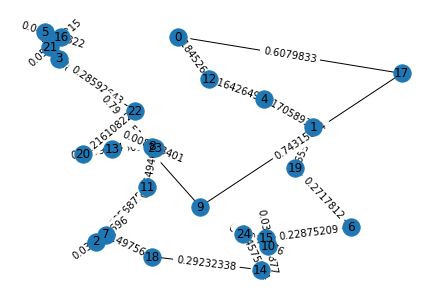

In [636]:

pie = get_tsp_pie( copy.deepcopy(agent.Q_table), init_state)
agent.Q_table
max_index_list = list(pie.argmax(axis = 1))

path = []
for i in range(len(max_index_list)):
    path += [(i, max_index_list[i])] 

new_g = set_tsp_graph(path )
new_g = set_euclidean_distance(new_g, pos)
draw_networkx_config(new_g, pos)

# nx.draw(new_g, pos)


print(agent.Q_table.argmax(1))
print(pie.argmax(axis = 1))
path



In [562]:
agent.Q_table

array([[           -inf,  0.00000000e+00,  0.00000000e+00,
         1.14966474e+02,  9.54541664e+01, -2.12685442e-01,
         0.00000000e+00,  0.00000000e+00, -2.59031814e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.36812845e+02,  0.00000000e+00,  3.45341195e+01,
         0.00000000e+00,  0.00000000e+00,  1.44311856e+02],
       [ 0.00000000e+00,            -inf,  0.00000000e+00,
         1.35273793e+02,  9.36292978e+01,  0.00000000e+00,
         1.41821214e+02,  0.00000000e+00,  0.00000000e+00,
        -2.57750219e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.62831794e+02,  2.45273016e+02],
       [ 1.21327445e+02,  0.00000000e+00,            -inf,
         2.72880450e+02, -4.25493050e-01,  0.00000000e+00,
         0.00000000e+00,  1.92110328e+02,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.54971126e+02,
         0.00000000e+00,  1.99812286e+02,  4.47542395e